# Training the extended rough Bergomi model part 2

In this notebook we train a neural network for the extended rough Bergomi model for expiries in the range (0.008,0.03].

Be aware that the datasets are rather large.


### Load, split and scale the datasets

In [1]:
import os, pandas as pd, numpy as np
wd = os.getcwd()

# Load contract grid:
logMoneyness = pd.read_csv(wd + '\\data\\logMoneyness.txt', delimiter=",", header = None).values
expiries = pd.read_csv(wd + '\\data\\expiries.txt', delimiter=",", header = None).values

# Set useful parameters:
nIn = 13
nOut = 150
nXi = 9

# Load training data:
data_train = pd.read_csv(wd + '\\data\\training_and_test_data\\rbergomi_extended\\rbergomi_extended_training_data_2.csv', delimiter=",").values
x_train = data_train[:,:nIn]
y_train = data_train[:,nIn:nIn+nOut]
data_train = None

# Load test data:
data_test = pd.read_csv(wd + '\\data\\training_and_test_data\\rbergomi_extended\\rbergomi_extended_test_data_2.csv', delimiter=",").values
x_valid = data_test[:,:nIn]
y_valid = data_test[:,nIn:nIn+nOut]
data_test = None

# Normalise data:
from sklearn.preprocessing import StandardScaler

tmp1 = np.reshape(np.array([3.50,0.00,0.50,0.50]), (1, 4))
tmp2 = np.reshape(np.array([0.75,-1.00,-0.50,-0.50]), (1, 4))
ub = np.concatenate((tmp1,np.tile(1,(1,nXi))),1)
lb = np.concatenate((tmp2,np.tile(0.0025,(1,nXi))),1)

def myscale(x):
    res=np.zeros(nIn)
    for i in range(nIn):
        res[i]=(x[i] - (ub[0,i] + lb[0,i])*0.5) * 2 / (ub[0,i] - lb[0,i])
        
    return res

def myinverse(x):
    res=np.zeros(nIn)
    for i in range(nIn):
        res[i]=x[i]*(ub[0,i] - lb[0,i]) *0.5 + (ub[0,i] + lb[0,i])*0.5
        
    return res

# Scale inputs:
x_train_mod = np.array([myscale(x) for x in x_train])
x_valid_mod = np.array([myscale(x) for x in x_valid])

# Scale and normalise output:
scale_y =  StandardScaler()
y_train_mod = scale_y.fit_transform(y_train)
y_valid_mod = scale_y.transform(y_valid)

### Define utility functions

In [2]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')

def GetNetwork(nIn,nOut,nNodes,nLayers,actFun):
    # Description: Creates a neural network of a specified structure
    input1 = keras.layers.Input(shape=(nIn,))
    layerTmp = keras.layers.Dense(nNodes,activation = actFun)(input1) 
    for i in range(nLayers-1):
        layerTmp = keras.layers.Dense(nNodes,activation = actFun)(layerTmp) 
    output1 = keras.layers.Dense(nOut,activation = 'linear')(layerTmp)
    return(keras.models.Model(inputs=input1, outputs=output1))

def TrainNetwork(nn,batchsize,numEpochs,objFun,optimizer,xTrain,yTrain,xTest,yTest):
    # Description: Trains a neural network and returns the network including the history
    # of the training process.
    nn.compile(loss = objFun, optimizer = optimizer)
    history = nn.fit(xTrain, yTrain, batch_size = batchsize,
                        validation_data = (xTest,yTest),
                        epochs = numEpochs, verbose = True, shuffle=1) 
    return nn,history.history['loss'],history.history['val_loss']

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square( y_pred - y_true )))

### Define and train neural network
<span style="color:red">This section can be skipped! Just go straight to "Load network" and load the already trained model</span>

In [ ]:
# Define model:
model = GetNetwork(nIn,nOut,200,3,'elu')

# Set seed
import random
random.seed(455165)

# Train network
model,loss1,vloss1 = TrainNetwork(model,32,500,root_mean_squared_error,'adam',x_train_mod,y_train_mod,x_valid_mod,y_valid_mod)
model,loss2,vloss2 = TrainNetwork(model,5000,200,root_mean_squared_error,'adam',x_train_mod,y_train_mod,x_valid_mod,y_valid_mod)

### Save network
<span style="color:red">This section can be skipped! Just go straight to "Load network" and load the already trained model</span>


In [ ]:
# Save model:
model.save(wd + '\\data\\neural_network_weights\\rbergomi_extended\\rbergomi_extended_model_2.h5')

# Save weights (and scalings) in JSON format:
# - You need to install 'json-tricks' first.
# - We need this file for proper import into Matlab, R... etc.
weights_and_more = model.get_weights()
weights_and_more.append(0.5*(ub + lb))
weights_and_more.append(np.power(0.5*(ub - lb),2))
weights_and_more.append(scale_y.mean_)
weights_and_more.append(scale_y.var_)

import codecs, json 
for idx, val in enumerate(weights_and_more):
    weights_and_more[idx] = weights_and_more[idx].tolist()

json_str = json.dumps(weights_and_more)

text_file = open(wd + "\\data\\neural_network_weights\\rbergomi_extended\\rbergomi_extended_weights_2.json", "w")
text_file.write(json_str)
text_file.close()

### Load network

In [3]:
# Load already trained neural network:
model = keras.models.load_model(wd + '\\data\\neural_network_weights\\rbergomi_extended\\rbergomi_extended_model_2.h5', 
                                custom_objects={'root_mean_squared_error': root_mean_squared_error})

### Validate approximation

Model Parameters (eta,rho,alpha,beta,xi1,xi2,...):  [ 1.84653434 -0.42026659 -0.27048499 -0.16128587  0.07526375  0.005625
  0.02045841  0.03773173  0.03249118  0.005625    0.005625    0.0787488
  0.04074594]


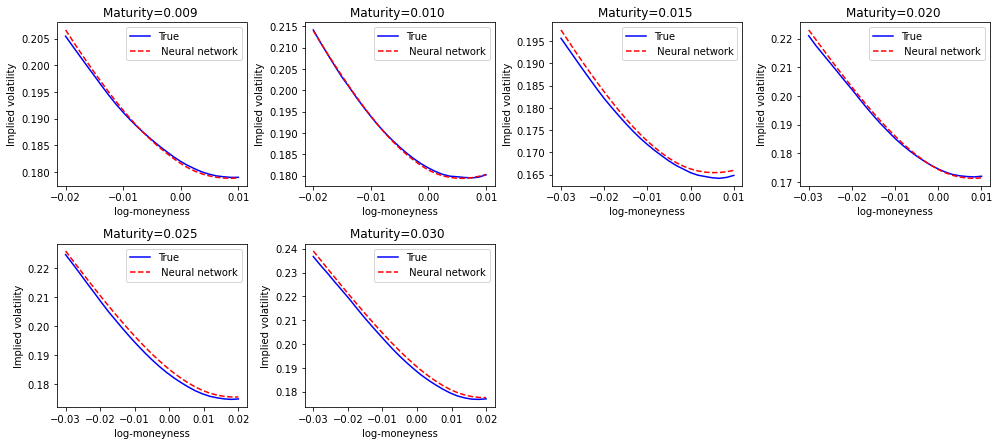

In [4]:
# Specify test sample to plot:
sample_ind = 5006

# Print parameters of test sample:
print("Model Parameters (eta,rho,alpha,beta,xi1,xi2,...): ",myinverse(x_valid_mod[sample_ind,:]))

import scipy, matplotlib.pyplot as plt
npts = 25
x_sample = x_valid_mod[sample_ind,:]
y_sample = y_valid_mod[sample_ind,:]

prediction = scale_y.inverse_transform(model.predict(x_valid_mod))
plt.figure(1,figsize=(14,12))
j = -1
for i in range(0,6):
    j = j + 1
    plt.subplot(4,4,j+1)
    
    plt.plot(logMoneyness[i*npts:(i+1)*npts],y_valid[sample_ind,i*npts:(i+1)*npts],'b',label="True")
    plt.plot(logMoneyness[i*npts:(i+1)*npts],prediction[sample_ind,i*npts:(i+1)*npts],'--r',label=" Neural network")

    plt.title("Maturity=%1.3f "%expiries[(i+7)*npts])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied volatility")
    
    plt.legend()
plt.tight_layout()
plt.show()